<h1 align="center">Detekcja anomalii transakcji finansowych przy użyciu autoenkodera</h1>

## Wprowadzenie

Celem niniejszego eksperymentu jest zbudowanie modelu uczenia maszynowego, zdolnego do wykrycia transakcji o charakterze wyłudzenia/oszustwa (fraud). Jest to zadanie polegające na detekcji anomalii, które może być realizowane na wiele sposobów (od prostych modeli regresji logistycznej po modele deep learningowe). Na potrzeby tej pracy zastosowano mniej popularną metodę, jaką jest sieć neuronowa typu autoenkoder oraz techniki ensemble. By wyjaśnić proponowane działanie modelu należy najpierw krótko przedstawić sieć typu autoenkoder:  


<div><br><br>
<img src="https://upload.wikimedia.org/wikipedia/commons/3/37/Autoencoder_schema.png" width="300"/><br><br>
</div>
  
  
Jak widać składa się on z części kodującej i dekodującej, oraz **warstwy ukrytej w środku**.
Sieć ta w potocznym rozumieniu potrafi nauczyć się reprezentować dane na swój, dla siebie zrozumiały sposób (**auto**enkoder). Może być używana do redukcji wymiarowości podobnie jak PCA czy TSNE, ale również klasyfikacji i związanej z tym poniekąd detekcji anomalii. W jaki sposób jest w stanie to robić? 

Zacznijmy od problemu klasyfikacji. Załóżmy, że nauczliśmy sieć na podstawie pewnych danych należących do jednej klasy. Teraz wprowadzamy nowe dane, pozwalamy je zakodować i ponownie odtworzyć do postaci pierwotnej. Mierząc błąd odtworzenia jesteśmy w stanie określić prawodpodobieństwo, że dane należą do tej samej klasy co dane ze zbioru uczącego.

Teraz łatwo można się domyślić jak można użyć autoenkodera do detekcji anomalii. Zastosujemy identyczne podejście jak w klasyfikacji i mierząc błąd odtworzenia będziemy chcieli określić, czy dana obserwacja jest anomalią - co poniekąd oznacza przynależność do pewnej klasy. 

Nieco ciekawszym i bardziej interesującym podejściem jest budowa modelu typu ensemble (modele złożone z kilku modeli), gdzie autoenkoder odwala całą brudną robotę, a za pomocą prostego liniowego klasyfikatora dokonujemy klasyfikacji danych na poprawne i odstające od normy. Cały problem związany z klasyfikacją danych na poprawne i podejrzane, polega na tym, że grupy te nie są od siebie separowalne. Jeśli zastosujemy autoenkoder typu "sparse-overcompleted" (rzadki-przepełniony) gdzie wymiarowość ukrytych warstw jest większa niż danych wejściowych, to liczymy że nauczy się on wewnętrznej reprezentacji, która zawiera więcej informacji - co za tym idzie, jest liniowo separowalna. Warto zauważyć że w tym podejściu użyjemy warstwy ukrytej bezpośrednio - w poprzedniej klasyfikacji błędem odtworzenia korzystamy z całego modelu.

Przyznaję, że pewnie brzmi to dosyć podejrzanie - dlaczego miałoby to zadziałać?
Prawdą jest, że autoenkodery mają swoje wady - trzeba uważać aby nie stworzyć funkcji tożsamościowej, aby ta wewnętrzna reprezentacja nie była tym samym co na wejściu, ale w innej formie. 
Można by zadać pytanie - dlaczego nie zastosujemy regresji logistycznej na samym początku (działa szybko, prosto i solidnie)?<br>
Wyjaśnienie jest jedno - mamy tu doczynienia z niesamowicie niezbalansowanym problemem. Nie mam na myśli tylko naszych danych z tego eksperymentu. **Każde dane tego typu** mają ten problem - ilość transakcji złych jest wielokrotnie mniejsza niż transakcji poprawnych. Z tego powodu klasyczne klasyfikatory na samym starcie są nietrafionym pomysłem i będą obarczone bardzo dużym błędem. Oczywiście istnieją metody do zastosowania, abyśmy mogli skorzystać z prostszych klasycznych modeli - jednak w tym badaniu nie będziemy się na nich skupiać. 

Całe badanie jest obarczone problemem silnie niezbalansowanych danych - z tego względu proszę o wybaczenie przy użyciu pewnych technik, które uwypuklają ten problem (jak macierz pomyłek). Zależało mi na jak najlepszym zobrazowaniu badania przy użyciu znanych metod. W poszczególnych krokach opisane zostały sposoby radzenia sobie z takimi danymi.
 
## Przygotowanie danych

Dane pochodzą z serwisu Kaggle (<a href="https://www.kaggle.com/mlg-ulb/creditcardfraud/home">dostępne tutaj</a>). Zawierają one dane na temat transakcji dokonanych kartami kredytowymi w Europie w ciągu dwóch dni we wrześniu 2013 roku. Dostępne jest tutaj niecałe 300 tysięcy takich transakcji, z czego niewielka część z nich to transakcje noszące znamiona oszustwa. Każda transakcja jest także oznaczona etykietą klasy: 1 oznacza oszustwo, a 0 prawidłową transakcję.

Wczytajmy dane i rzućmy na nie okiem.

In [1]:
from keras.layers import Input, Dense
from keras.models import Model, Sequential
from keras import regularizers
from sklearn.model_selection import train_test_split 
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.manifold import TSNE
from sklearn import preprocessing 
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np
import seaborn as sns
SEED = 15685
np.random.seed(SEED)
sns.set_style("whitegrid")
pd.set_option('display.float_format', lambda x: '%.4f' % x)

fraud_data = pd.read_csv("creditcard.csv")
fraud_data.head()

Using TensorFlow backend.


Time      V1      V2     V3      V4      V5      V6      V7      V8  \
0 0.0000 -1.3598 -0.0728 2.5363  1.3782 -0.3383  0.4624  0.2396  0.0987   
1 0.0000  1.1919  0.2662 0.1665  0.4482  0.0600 -0.0824 -0.0788  0.0851   
2 1.0000 -1.3584 -1.3402 1.7732  0.3798 -0.5032  1.8005  0.7915  0.2477   
3 1.0000 -0.9663 -0.1852 1.7930 -0.8633 -0.0103  1.2472  0.2376  0.3774   
4 2.0000 -1.1582  0.8777 1.5487  0.4030 -0.4072  0.0959  0.5929 -0.2705   

       V9  ...     V21     V22     V23     V24     V25     V26     V27  \
0  0.3638  ... -0.0183  0.2778 -0.1105  0.0669  0.1285 -0.1891  0.1336   
1 -0.2554  ... -0.2258 -0.6387  0.1013 -0.3398  0.1672  0.1259 -0.0090   
2 -1.5147  ...  0.2480  0.7717  0.9094 -0.6893 -0.3276 -0.1391 -0.0554   
3 -1.3870  ... -0.1083  0.0053 -0.1903 -1.1756  0.6474 -0.2219  0.0627   
4  0.8177  ... -0.0094  0.7983 -0.1375  0.1413 -0.2060  0.5023  0.2194   

      V28   Amount  Class  
0 -0.0211 149.6200      0  
1  0.0147   2.6900      0  
2 -0.0598 378.6600      0  
3  0.0615 123.5000      0  
4  0.2152  69.9900      0  

[5 rows x 31 columns]

Zmienne od V1 do V28 powstały poprzez transformację większej ilości zmiennych w procesie PCA (principal component analysis). Zrobiono to aby zanonimizować dane. Kolumna 'time' zawiera czas od pierwszej transakcji w zbiorze a kolumna 'amount' wartość danej transakcji w euro.<br><br>
Rzućmy okiem ponownie w poszukiwaniu średniej, odchylenia standardowego i brakujących wartości.

In [4]:
pd.DataFrame({'mean':fraud_data.mean(),'std':fraud_data.std(),'nans':fraud_data.isna().sum()}).transpose()

Time     V1     V2      V3     V4     V5     V6      V7     V8  \
mean 94813.8596 0.0000 0.0000 -0.0000 0.0000 0.0000 0.0000 -0.0000 0.0000   
std  47488.1460 1.9587 1.6513  1.5163 1.4159 1.3802 1.3323  1.2371 1.1944   
nans     0.0000 0.0000 0.0000  0.0000 0.0000 0.0000 0.0000  0.0000 0.0000   

          V9  ...    V21     V22    V23    V24    V25    V26     V27     V28  \
mean -0.0000  ... 0.0000 -0.0000 0.0000 0.0000 0.0000 0.0000 -0.0000 -0.0000   
std   1.0986  ... 0.7345  0.7257 0.6245 0.6056 0.5213 0.4822  0.4036  0.3301   
nans  0.0000  ... 0.0000  0.0000 0.0000 0.0000 0.0000 0.0000  0.0000  0.0000   

       Amount  Class  
mean  88.3496 0.0017  
std  250.1201 0.0415  
nans   0.0000 0.0000  

[3 rows x 31 columns]

Szczęśliwe nie ma brakujących wartości w żadnej z kolumn. Kolumny powstałe w wyniku PCA nie potrzebują specjalnego traktowania - nie wiemy nic o danych źródłowych, a podczas PCA dane zostały zeskalowane (o czym więcej w dalszej części). Trzeba dokładniej spojrzeć na kolumnę time - w obecnej postaci nie powinniśmy jej używać. Przy okazji popatrzymy na rozkład wartości transakcji.

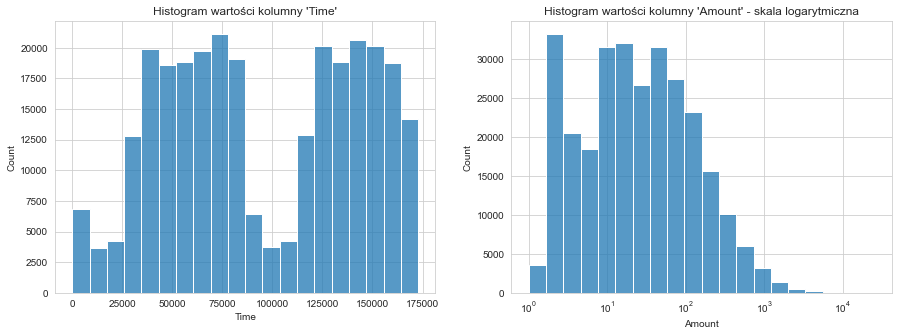

In [3]:
fig, axs = plt.subplots(ncols=2, figsize=(15,5))
hist1 = sns.histplot(data=fraud_data['Time'], bins="sturges", ax=axs[0])
hist2 = sns.histplot(data=fraud_data['Amount']+1, log_scale=True, bins="sturges", ax=axs[1])
axs[0].set_title("Histogram wartości kolumny 'Time'");
axs[1].set_title("Histogram wartości kolumny 'Amount' - skala logarytmiczna");

Krótko o kolumnie 'Amount' - rozkład zbliżony do normalnego, mocno prawoskośny, co było do przewidzenia. Więcej jest małych transakcji niż dużych. <br><br>
Kolumna 'Time' przedstawia "odległość czasową w sekundach" transakcji od pierwszej w zbiorze - widać na histogramie, że mamy tu ~dwa dni danych. Sam czas nie ma dla nas znaczenia, ale już pora (godzina) może mieć ogromne. Dlatego przekształcimy tę kolumnę do odpowiedniej postaci. <br><br>
Ostatnią operacją przed jakimkolwiek użyciem danych będzie sprawdzenie ich zbalansowania względem klasy.

In [5]:
fraud_data["Time"] = fraud_data["Time"].apply(lambda x : x / 3600 % 24)
vc = fraud_data['Class'].value_counts()
print("{0:.2%} procent oszustw".format(vc[1]/(vc[0]+vc[1])))

0.17% procent oszustw


## TSNE - wizualizacja danych wielowymiarowych

Jak widać mamy tutaj ogromną nadreprezentację normalnych transakcji i niedobór oszustw. Jest to największe przekleństwo przy budowaniu tego typu modeli i bardzo częsta sytuacja. Z tego względu wiele technik jakich moglibyśmy użyć, musimy odrzucić. Należy zachować ogromną ostrożność stosując te dane.<br>
Ciekawą techniką wizualizacji danych wielowymiarowych na mniejszą liczbę wymiarów jest TSNE (w odróżnieniu od np. PCA, jest to technika probabilistyczna). Przeprowadźmy taką symulacje na 1000 transakcji normalnych i wszystkich oszustwach. 



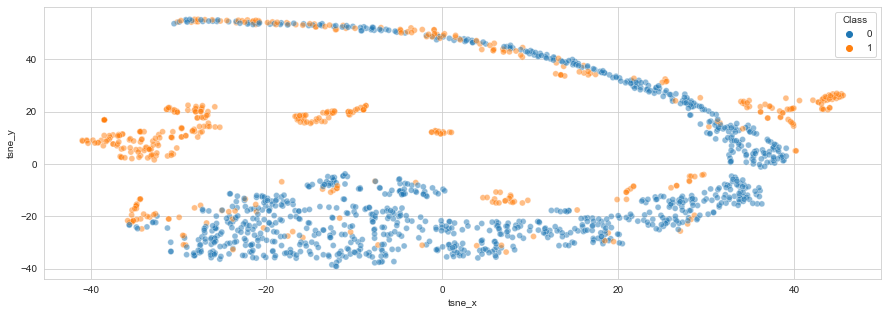

In [6]:
legit = fraud_data[fraud_data['Class'] == 0].sample(1000, random_state=SEED)
fraud = fraud_data[fraud_data['Class'] == 1]
tsne_data = legit.append(fraud).sample(frac=1).reset_index(drop=True)
tsne = TSNE(n_components=2, random_state=SEED)
tsne_results = tsne.fit_transform(tsne_data.drop(['Class'], axis = 1).values)
tsne_data["tsne_x"] = tsne_results[:,0]
tsne_data["tsne_y"] = tsne_results[:,1]
plt.figure(figsize=(15,5))
sns.scatterplot(x="tsne_x", y="tsne_y", hue="Class", legend="full", data=tsne_data, alpha=0.5);



Jak widać, część danych jest od siebie zdecydowanie separowalna w tym momencie. Natomiast mamy również dużo punktów schowanych pomiędzy prawidłowymi transakcjami. Naszym celem jest "wyłuskanie" możliwie największej liczby tych punktów, spomiędzy niebieskich grup.<br><br>
W tym celu użyjemy autoenkodera.

## Budowa sieci

Autoenkodery dzielą się jak większość sieci na wiele podtypów. Na potrzeby tego eksperymentu zbudujemy dwa rodzaje tej sieci. Nazywają się one undercomplete i overcomplete - "przepełniony i niepełny" jak można by to przetłumaczyć. Różnią się one ilością neuronów w warstwach ukrytych. Autoenkodery przepełnione zawierają ich więcej niż warstwy wejścia/wyjścia, a niepełne zawierają ich mniej. <br><br>
Nasz przepełniony autoenkoder dodatkowo będziemy "rzadkim" (sparse) autoenkoderem - czyli dołożymy karę za użycie wielu neuronów w warstwie ukrytej. W ten sposób chronimy autoenkoder przed zostaniem funkcją tożsamościową. Chcemy uzyskać nową/lepszą reprezentację, a nie taką samą ale bardziej skomplikowaną. <br><br>
W wypadku autoenkodera niepełnego sytuacja jest prostsza - tam nie musimy stosować takich technik. <br><br>
Liczba warstw jak i neuronów została dobrana eksperymentalnie - zachowując balans pomiędzy złożonością i skutecznością modelu.


In [7]:
io_shape = fraud_data.shape[1]-1
learning_rate = 10e-5
input_layer = Input(shape=(io_shape,))

uc_encoder = Dense(32, activation='elu')(input_layer)
uc_encoder = Dense(16, activation='relu')(uc_encoder)
uc_decoder = Dense(32, activation='relu')(uc_encoder)
uc_decoder = Dense(io_shape, activation='elu')(uc_decoder)

oc_encoder = Dense(64, activation='elu'
                ,activity_regularizer=regularizers.l1(learning_rate)
               )(input_layer)
oc_encoder = Dense(128, activation='relu')(oc_encoder)
oc_decoder = Dense(64, activation='relu')(oc_encoder)
oc_decoder = Dense(io_shape, activation='elu')(oc_decoder)
 


Mamy przygotowane warstwy - czas skompilować i podsumować strukturę modeli.<br>

In [11]:
uc_autoencoder, oc_autoencoder = Model(input_layer, uc_decoder, 
                                       name="Undercomplete autoencoder"), Model(input_layer, oc_decoder,
                                       name="Overcomplete autoencoder")
autoencoders = [uc_autoencoder, oc_autoencoder]
for ac in autoencoders:
    ac.compile(optimizer='adam',
                metrics=['accuracy'],
                loss='mean_squared_error')
    ac.summary()


Model: "Undercomplete autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 30)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                992       
_________________________________________________________________
dense_2 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_3 (Dense)              (None, 32)                544       
_________________________________________________________________
dense_4 (Dense)              (None, 30)                990       
Total params: 3,054
Trainable params: 3,054
Non-trainable params: 0
_________________________________________________________________
Model: "Overcomplete autoencoder"
_________________________________________________________________
Layer

## Podział danych i trenowanie autoenkoderów
Jak wcześniej zostało wspomniane musimy jeszcze przeskalować dane (a z pewnością kolumny Time i Amount). Dlaczego decyduje się na skalowanie również kolumn powstałych w wyniku PCA? Będziemy musieli użyć wartości zwanej błędem odtworzenia - korzysta ona z danych. Łatwiej będzie nam jeśli wszystkie wartości będą w przedziale [0,1]<br><br>
**Bardzo ważną czynnością jest podział na dane testowe i treningowe już w tym momencie**
W ten sposób mamy całkowitą pewność że model nie miał dostępu do danych testowych w czasie trenowania (co jest nagminnym błędem w rozmaitych opracowaniach). Co bardzo istotne - **nasz autoenkoder karmimy tylko i wyłącznie danymi dobrych transakcji!** Chcemy nauczyć go kodować dobre transakcje - przecież liczymy, że dzięki temu będzie źle odtwarzał transakcje fałszywe.

In [81]:
x = fraud_data.drop(["Class"], axis=1)
y = fraud_data["Class"].values
x_scale = preprocessing.MinMaxScaler().fit_transform(x.values)
x_norm, x_fraud = x_scale[y == 0], x_scale[y == 1]

x_train, x_test = train_test_split(x_norm,shuffle=True, test_size=0.01)
y_test = np.append(np.zeros(x_test.shape[0]),np.ones(x_fraud.shape[0]))
x_test = np.vstack((x_test,x_fraud))
y_train = np.zeros(x_train.shape[0])

Czas na wytrenowanie naszych autoenkoderów - stosujemy dosyć mały batch_size i duży zbiór walidacyjny (mamy ogrom dobrych transakcji). Oczywiście dzięki zastosowaniom callbacków liczba epok ma nikłe znaczenie. Stosujemy checkpointy modeli oraz earlystopper - żeby model się nie trenował kiedy nie uzyskuje poprawy, oraz żebyśmy zawsze dysponowali jego najlepszą wersją.

In [36]:
for autoencoder in autoencoders:
    print("Training: " + autoencoder.name)
    ModelCheck = ModelCheckpoint(filepath=autoencoder.name+'.h5', 
                             monitor='accuracy', save_best_only=True, 
                             verbose=1)
    EarlyStop = EarlyStopping(monitor='accuracy', patience=4, min_delta=10e-3, verbose=1)
    history = autoencoder.fit(x_train, x_train, 
                    batch_size = 512, epochs = 50, 
                    shuffle = True, validation_split = 0.3,
                    callbacks = [EarlyStop, ModelCheck]);
    print("\n\n")

Training: Undercomplete autoencoder
Train on 197029 samples, validate on 84442 samples
Epoch 1/50
197029/197029 [==============================] - 2s 9us/step - loss: 2.6346e-04 - accuracy: 0.9690 - val_loss: 2.6606e-04 - val_accuracy: 0.9696

Epoch 00001: accuracy improved from -inf to 0.96898, saving model to Undercomplete autoencoder.h5
Epoch 2/50
197029/197029 [==============================] - 2s 8us/step - loss: 2.6308e-04 - accuracy: 0.9689 - val_loss: 2.6696e-04 - val_accuracy: 0.9694

Epoch 00002: accuracy did not improve from 0.96898
Epoch 3/50
197029/197029 [==============================] - 2s 8us/step - loss: 2.6238e-04 - accuracy: 0.9687 - val_loss: 2.6693e-04 - val_accuracy: 0.9685

Epoch 00003: accuracy did not improve from 0.96898
Epoch 4/50
197029/197029 [==============================] - 2s 9us/step - loss: 2.6220e-04 - accuracy: 0.9687 - val_loss: 2.6521e-04 - val_accuracy: 0.9691

Epoch 00004: accuracy did not improve from 0.96898
Epoch 5/50
197029/197029 [========

## Klasyfikacja na podstawie błędu odtworzenia 

Zaczniemy od predykcji (zakodowania w tym wypadku) naszego zbioru testowego - jako że mamy dwa autoenkodery, to wszystko wykonujemy dwukrotnie. Intuicja jest taka że w tym wypadku autoenkoder niepełny powinien działać lepiej niż przepełniony.<br><br>
Obliczamy błąd odtworzenia dla każdego wiersza i ustalamy pewien próg (tutaj obliczonego jako średnia + 1/2 odchylenia standardowego dla normalnych transakcji). Jeśli wartość błędu odtworzenia go przekracza, to uznajemy że transakcja jest oszustwem.<br><br>
Wstępne wyniki przedstawię w formie macierzy pomyłek (zdając sobie sprawę, że w przypadku niezbalansowanych danych nie jest to najlepsza forma wizualizacji). Popatrzmy:

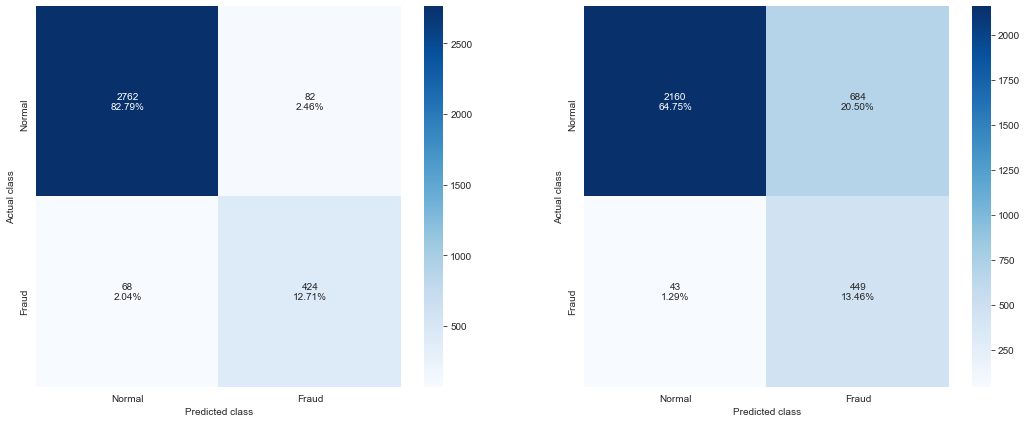

In [103]:
fig, axis = plt.subplots(ncols=2, figsize=(18,7))
class_reports = []
for i,autoencoder in enumerate(autoencoders):
    X_test_pred = autoencoder.predict(x_test)
    mse = np.mean(np.power(x_test - X_test_pred, 2), axis=1)
    df_error = pd.DataFrame({'Class': y_test, 'reconstruction_error': mse})
    normal_mean = df_error.loc[df_error["Class"]==0]['reconstruction_error'].mean()
    total_std = df_error.loc[df_error["Class"]==0]['reconstruction_error'].std()
    threshold = normal_mean + total_std/2
    y_pred = [0 if e < threshold else
              1 for e in df_error['reconstruction_error'].values]
    cf_matrix = confusion_matrix(df_error['Class'], y_pred)
    group_counts = ['{0:0.0f}'.format(value) for value in
                    cf_matrix.flatten()]
    group_percentages = ['{0:.2%}'.format(value) for value in
                         cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [f'{v2}\n{v3}' for v2, v3 in
              zip(group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues', xticklabels=['Normal','Fraud'], 
                yticklabels=['Normal','Fraud'], ax=axis[i])
    axis[i].set(xlabel='Predicted class', ylabel='Actual class')
    class_reports.append(autoencoder.name + '\n' +
                         classification_report(df_error['Class'], y_pred))

In [93]:
for report in class_reports:
    print(report)

Undercomplete autoencoder
              precision    recall  f1-score   support

         0.0       0.98      0.97      0.97      2844
         1.0       0.84      0.86      0.85       492

    accuracy                           0.96      3336
   macro avg       0.91      0.92      0.91      3336
weighted avg       0.96      0.96      0.96      3336

Overcomplete autoencoder
              precision    recall  f1-score   support

         0.0       0.98      0.76      0.86      2844
         1.0       0.40      0.91      0.55       492

    accuracy                           0.78      3336
   macro avg       0.69      0.84      0.70      3336
weighted avg       0.89      0.78      0.81      3336



Zgodnie z intuicją autoenkoder niepełny wypada zdecydowanie lepiej jeśli chodzi o balans między czułością a swoistością. Co prawda drugi autoenkoder łapie kilka oszustw więcej, ale kompletnie wariuje jeśli chodzi o ilość wyników fałszywie pozytywnych. <br><br>
Tak naprawdę decyzję o wyborze modelu należałoby podjąć po dyskusji z klientem, ekspertami w dziedzine, ustalając jaki proces ma towarzyszyć transakcji. Jeśli wynik pozytywny byłby weryfikowany SMSem czy notyfikacją PUSH to rzeczywiście drugi model wydaje się być wart uwagi. Jeśli byłby to jeden z ostatnich etapów, wtedy model pierwszy jest bardziej ogólny i bezpieczny.<br><br>
My nie będziemy się nad tym długo zastanawiać i przejdziemy do budowy modelu ensemble z wykorzystaniem postaci ukrytej danych i regresji logistycznej.<br>
## Budowa modelu ensemble z wykorzystaniem ukrytej postaci danych w autoenkoderze
Najpierw należy zbudować sieć z wag modelu pozwalającą na uzyskanie postaci ukrytej.

In [78]:
hidden_representation = Sequential()
hidden_representation.add(autoencoders[1].layers[0])
hidden_representation.add(autoencoders[1].layers[1])
hidden_representation.add(autoencoders[1].layers[2])

Mamy już zbudowany model generujący ukrytą postać - czas na transformację danych testowych

In [79]:
x_test_hid = hidden_representation.predict(x_test)

Z ciekawości sprawdźmy jak prezentuja się ukryta postać danych

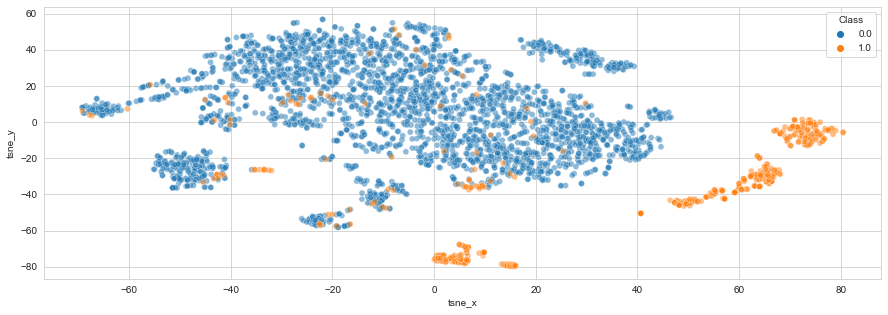

In [61]:
tsne_data_en = pd.DataFrame(data=np.column_stack((x_test_hid,y_test)))
tsne_data_en.columns = ['X'+str(i) for i in range(x_test_hid.shape[1])]+['Class']
tsne_en = TSNE(n_components=2, random_state=SEED)
tsne_results_en = tsne_en.fit_transform(tsne_data_en.drop(['Class'], axis = 1).values)
tsne_data_en["tsne_x"] = tsne_results_en[:,0]
tsne_data_en["tsne_y"] = tsne_results_en[:,1]
plt.figure(figsize=(15,5))
sns.scatterplot(x="tsne_x", y="tsne_y", hue="Class", legend="full", data=tsne_data_en, alpha=0.5);

Super! Brak ogona, osobne grupy, ale trzeba też zauważyc wciąż pochowane w niebieskich skupiskach małe pomarańczowe kropki... Zobaczmy czy nasz model ensemble sobie z tym poradzi

## Model regresji liniowej na danych w postaci ukrytej z autoenkodera - trening i ewaluacja
Podsumujmy co już uzyskaliśmy i chcemy zrobić.<br>
<ul>
<li>Mamy dane w ukrytej postaci z przepełnionego (overcompleted) autoenkodera.</li>
<li>Podzielimy je na dane testowe i treningowe z uwzględnieniem słabego rozdziału klas (opcja stratify).</li>
<li>Zbudujemy model regresji liniowej z rekursyjnym usuwaniem predyktorów na podstawie p-value (bardzo dyskusyjne jest tutaj usuwanie zmiennych, ale doświadczenie mówi mi że warto spróbować).</li>
<li>Dokonamy klasyfikacji próbki testowej i zobaczymy jakie wyniki uzyskaliśmy</li>
    </ul>

              precision    recall  f1-score   support

         0.0       0.97      1.00      0.98       853
         1.0       0.98      0.80      0.88       148

    accuracy                           0.97      1001
   macro avg       0.97      0.90      0.93      1001
weighted avg       0.97      0.97      0.97      1001



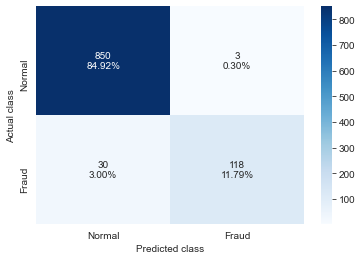

In [147]:
train_x, val_x, train_y, val_y = train_test_split(x_test_hid, y_test, test_size=0.3, 
                                                  random_state=SEED, stratify=y_test)
clf = LogisticRegression(solver="lbfgs")
selector = RFE(clf, step=1)
selector.fit(train_x, train_y)
pred_y = (selector.predict_proba(val_x)[:,1]>0.1).flatten().astype(int)
print (classification_report(val_y, pred_y))
cf_matrix = confusion_matrix(val_y,pred_y)
group_counts = ['{0:0.0f}'.format(value) for value in
                cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f'{v2}\n{v3}' for v2, v3 in
          zip(group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues', xticklabels=['Normal','Fraud'], 
            yticklabels=['Normal','Fraud'], )
plt.xlabel("Predicted class");
plt.ylabel("Actual class");

## Podsumowanie wyników
Wyniki wyglądają obiecująco - na 148 oszustw wykryliśmy poprawnie 30, biorąc jako próg 10% prawdopodobieństwo wygenerowane przez nasz klasyfikator. 80% oszustw zostało poprawnie znalezionych (przy tylko 3 fałszywie pozytywnych wynikach!). W porównaniu do metody z użyciem błędu odtworzenia wypadliśmy trochę gorzej jeśli chodzi o identyfikację oszustów, ale dużo lepiej jeśli chodzi o fałszywie pozytywne wyniki<br><br>
W tym momencie wydaje się mi, że należy zakończyć pracę i cieszyć się rezultatem. Znaleźliśmy dobry kompromis między czułością i swoistością, stoimy na krawędzi przepaści - przeuczenia lub zburzenia balansu. Obawiam się, że uzyskanie znacznie lepszych wyników (usunięcie 30 źle sklasyfikowanych oszustw) jest mało możliwe, i zahacza o data-dredging. Najmądrzej w tym momencie należało by porozmawiać z klientem o możliwośći pozyskania dodatkowych danych<br><br>
Jako pewien smaczek przedstawię co by się stało gdybyśmy zastosowali liniową regresję na surowych danych :)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    142158
           1       0.85      0.68      0.76       246

    accuracy                           1.00    142404
   macro avg       0.93      0.84      0.88    142404
weighted avg       1.00      1.00      1.00    142404



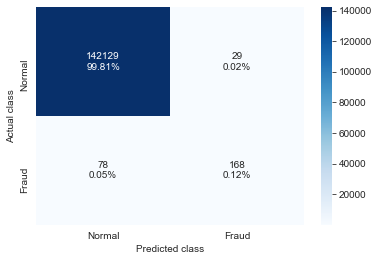

In [161]:
train_x, val_x, train_y, val_y = train_test_split(x_scale, fraud_data['Class'].values, 
                                                  test_size=0.50, stratify=fraud_data['Class'].values,
                                                  random_state=SEED)
clf = LogisticRegression(solver="lbfgs").fit(train_x,train_y)
pred_y = (clf.predict_proba(val_x)[:,1]>0.1).flatten().astype(int)
print (classification_report(val_y, pred_y))
cf_matrix = confusion_matrix(val_y,pred_y)
group_counts = ['{0:0.0f}'.format(value) for value in
                cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f'{v2}\n{v3}' for v2, v3 in
          zip(group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues', xticklabels=['Normal','Fraud'], 
            yticklabels=['Normal','Fraud'], )
plt.xlabel("Predicted class");
plt.ylabel("Actual class");

78/168 oszustw zostało źle sklasyfikowane (sic!) 68% oszustw zostało odnalezionych - niestety wyniki nie są optymistyczne.<br>
Przy okazji świetny przykład dlaczego macierz pomyłek nie jest najlepszym pomysłem do wizualizacji tego zadania.